In [2]:
pip install tensorflow


  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached namex-0.0.8-py3-none-any.whl.metadata (246 bytes)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
   ---------------------------------------- 0.0/390.3 MB ? eta -:--:--
   ---------------------------------------- 1.6/390.3 MB 7.6 MB/s eta 0:00:52
   ---------------------------------------- 3.7/390.3 MB 9.1 MB/s eta 0:00:43
    --------------------------------------- 6.0/390.3 MB 9.5 MB/s eta 0:00:41
    --------------------------------------- 8.4/390.3 MB 10.2 MB/s eta 0:00:38
   - -------------------------------------- 10.7/390.3 MB 10.3 MB/s eta 0:00:37
   - -------------------------

In [3]:
# 2021A7PS0203U
# Harshadeep Chowdary Kommareddi

from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from keras.models import Sequential
from keras.layers import Input, Masking, Conv1D, MaxPooling1D, LSTM, Dropout, Dense
from keras.optimizers import Adam
from keras.utils import pad_sequences
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

file_path = "/Users/harsh/Downloads/archive/data.csv"
data = pd.read_csv(file_path)

X = data.drop(columns=["Bankrupt?"]).values
y = data["Bankrupt?"].values.astype("int64") 

scaler = StandardScaler()
X = scaler.fit_transform(X)

n_components = 75 
pca = PCA(n_components=n_components)
X_reduced = pca.fit_transform(X)

explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained Variance Ratio by PCA: {explained_variance_ratio}")
print(f"Total Variance Explained: {sum(explained_variance_ratio):.2f}")

sequence_length = 1
num_features = X_reduced.shape[1]

X_grouped = [X_reduced[i].reshape(sequence_length, num_features) for i in range(len(X))]
y_grouped = y.tolist()

X_padded = pad_sequences(X_grouped, maxlen=sequence_length, dtype='float32', padding='post', truncating='post')
y_padded = np.array(y_grouped).astype('float32')

X_train, X_val, y_train, y_val = train_test_split(X_padded, y_padded, test_size=0.3, random_state=42)

X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_val_2d = X_val.reshape(X_val.shape[0], -1)

smote = SMOTE(random_state=42)
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train_2d, y_train)

X_train_oversampled = X_train_oversampled.reshape(X_train_oversampled.shape[0], sequence_length, num_features)
X_val = X_val_2d.reshape(X_val_2d.shape[0], sequence_length, num_features)

model = Sequential()

# i/p & masking layer
model.add(Input(shape=(sequence_length, num_features)))
model.add(Masking(mask_value=0.0))

# Conv layer 1 (with MaxPooling)
model.add(Conv1D(64, 3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=1))

# lstm layer1
model.add(LSTM(128, return_sequences=True, activation='tanh'))
model.add(Dropout(0.3))

# lstm layer2
model.add(LSTM(64, return_sequences=False, activation='tanh'))
model.add(Dropout(0.3))

# dense layer
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

# o/p layer
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

history = model.fit(
    X_train_oversampled, y_train_oversampled,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)

val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Explained Variance Ratio by PCA: [0.13346977 0.07213753 0.05036685 0.04724484 0.04234718 0.0322023
 0.03049291 0.02934268 0.0280185  0.02156488 0.02059148 0.01984625
 0.0178892  0.01600532 0.01577908 0.01533237 0.01514449 0.01397153
 0.01314868 0.01274245 0.01248121 0.01217504 0.01160926 0.01119518
 0.01110326 0.01099148 0.01075571 0.01073014 0.01071275 0.01048095
 0.01038181 0.01026907 0.01018961 0.01013562 0.00998788 0.00978913
 0.00969166 0.0096509  0.00936015 0.00908422 0.00900332 0.00883054
 0.00853073 0.00845686 0.00804693 0.00762726 0.00729723 0.007007
 0.00638461 0.00605721 0.0057794  0.00573047 0.00534135 0.00496513
 0.00450023 0.00438088 0.00411521 0.00346504 0.00344533 0.00266464
 0.00260696 0.00229752 0.00228159 0.00179802 0.00176183 0.00164633
 0.00149517 0.00119626 0.00090187 0.00087436 0.00067739 0.00057107
 0.00039941 0.00030955 0.00026104]
Total Variance Explained: 1.00


c:\Users\harsh\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\harsh\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
c:\Users\harsh\anaconda3\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 1, 75)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1, 64)          │        14,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 1, 128)         │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,801 (643.75 KB)

 Trainable params: 164,801 (643.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8349 - loss: 0.4148 - val_accuracy: 0.8978 - val_loss: 0.2920
Epoch 2/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9501 - loss: 0.1554 - val_accuracy: 0.9208 - val_loss: 0.3126
Epoch 3/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9694 - loss: 0.1109 - val_accuracy: 0.9365 - val_loss: 0.2953
Epoch 4/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9775 - loss: 0.0855 - val_accuracy: 0.9374 - val_loss: 0.2792
Epoch 5/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9854 - loss: 0.0561 - val_accuracy: 0.9497 - val_loss: 0.2787
Epoch 6/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9874 - loss: 0.0505 - val_accuracy: 0.9438 - val_loss: 0.3159
Epoch 7/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9896 - loss: 0.0446 - val_accuracy: 0.9423 - val_loss: 0.2825
Epoch 8/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9918 - loss: 0.0372 - val_accuracy: 0.

## Confusion Matrix

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98      1968
         1.0       0.37      0.33      0.35        78

    accuracy                           0.95      2046
   macro avg       0.67      0.66      0.66      2046
weighted avg       0.95      0.95      0.95      2046

ROC-AUC Score: 0.8775211069418387


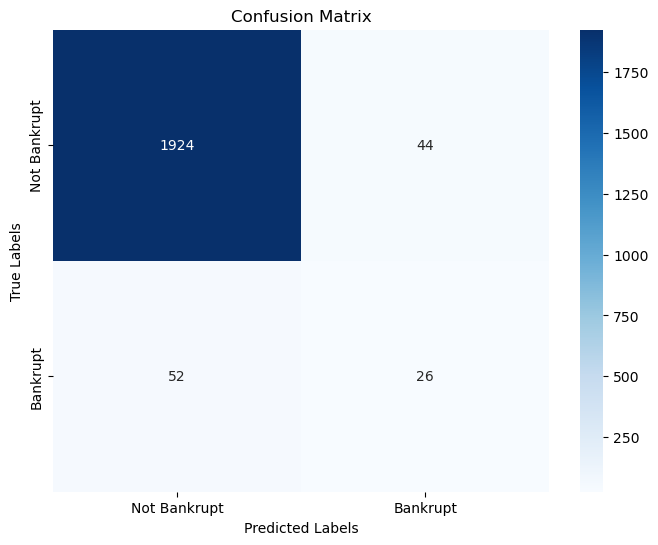

In [4]:
y_val_pred = model.predict(X_val)
y_val_pred_binary = (y_val_pred > 0.5).astype(int)

print(classification_report(y_val, y_val_pred_binary))
print("ROC-AUC Score:", roc_auc_score(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Bankrupt', 'Bankrupt'], yticklabels=['Not Bankrupt', 'Bankrupt'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## ROC curve and AUC analysis

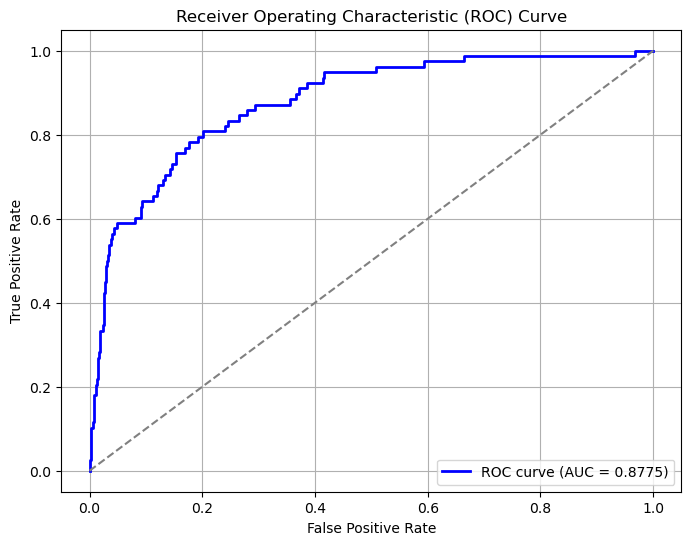

AUC: 0.8775


In [5]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"AUC: {roc_auc:.4f}")


## Learning Curve: training and validation accuracy

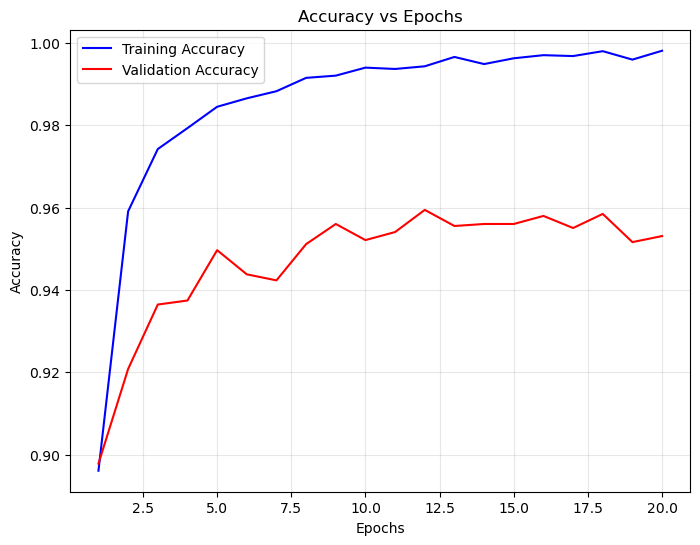

In [6]:
def plot_accuracy_curve(history):
  train_accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  plt.figure(figsize=(8, 6))
  plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy', color='blue')
  plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy', color='red')
  plt.title('Accuracy vs Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True, alpha=0.3)
  plt.show()


plot_accuracy_curve(history)

## Learning Curve: training and validation loss

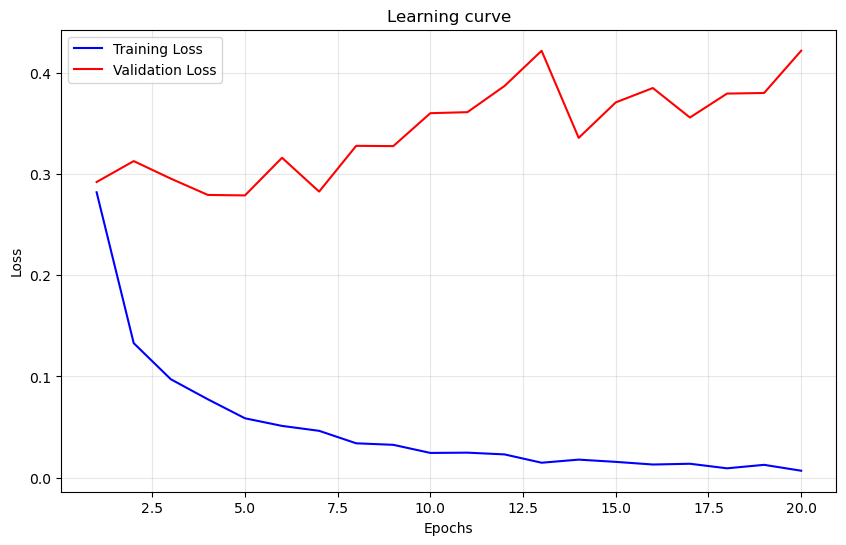

In [7]:
def plot_learning_curve(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)

  plt.figure(figsize=(10,6))
  plt.plot(epochs, loss, 'b-', label='Training Loss')
  plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
  plt.title(f'Learning curve')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True, alpha=0.3)
  plt.show()
  plt.close()

plot_learning_curve(history)
